In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/storage/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [30]:
learn = collab_learner(data, use_nn=True, emb_szs= y_range=y_range)

TypeError: object of type 'NoneType' has no len()

In [84]:
print(ifnone(None, [0]*len(5)))

TypeError: object of type 'int' has no len()

epoch,train_loss,valid_loss,time
0,1.828229,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


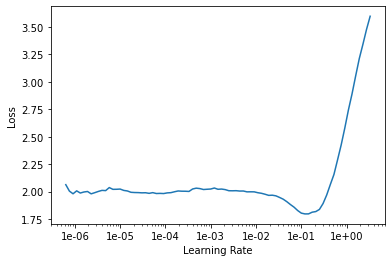

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.860503,1.631442,00:00
1,0.960928,0.687098,00:00
2,0.700781,0.656639,00:00
3,0.584911,0.642584,00:00
4,0.527633,0.641199,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [39]:
path=Config.data_path()/'data/ml-100k'
print(path)

/storage/data/ml-100k


In [41]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [42]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
len(ratings)

100000

In [46]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [47]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [53]:
data.show_batch()

userId,title,target
328,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.0
398,I.Q. (1994),3.0
264,"Princess Bride, The (1987)",5.0
682,Independence Day (ID4) (1996),4.0
151,Sunset Blvd. (1950),4.0


In [54]:
y_range = [0,5.5]

In [55]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


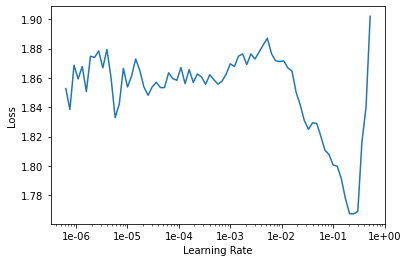

In [56]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [57]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.972074,0.955617,00:04
1,0.870553,0.885072,00:04
2,0.756219,0.836203,00:04
3,0.644037,0.814749,00:04
4,0.591894,0.813417,00:04


In [58]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [59]:
learn.load('dotprod');

In [60]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [63]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [64]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [72]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [73]:
item0 = lambda o:o[0]

In [74]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3756),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2863),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2821), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2588), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2508), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2404), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2398), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2378), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2320), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2319), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2245), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2210), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2193), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2024), 'Grease 2 (1982)', 2.0),
 (tensor(-0.1977), 'Le

In [71]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6182), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5774), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5709), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5534), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5403), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5347), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5212), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5139), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4967), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4962), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4828), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4818), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4772), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4758), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4728), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [75]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [76]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [77]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [78]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1341), 'Casablanca (1942)'),
 (tensor(1.0868), 'Wrong Trousers, The (1993)'),
 (tensor(1.0681), 'Close Shave, A (1995)'),
 (tensor(1.0250), 'Chinatown (1974)'),
 (tensor(0.9927),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9804), 'Godfather, The (1972)'),
 (tensor(0.9491), 'Secrets & Lies (1996)'),
 (tensor(0.9464), 'Big Sleep, The (1946)'),
 (tensor(0.9345), 'Ran (1985)'),
 (tensor(0.9338), 'Citizen Kane (1941)')]

In [79]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2925), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.2630), 'Home Alone 3 (1997)'),
 (tensor(-1.2508), "McHale's Navy (1997)"),
 (tensor(-1.2338), 'Jungle2Jungle (1997)'),
 (tensor(-1.2055), 'Bio-Dome (1996)'),
 (tensor(-1.1949), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1334), 'Congo (1995)'),
 (tensor(-1.1303), 'Leave It to Beaver (1997)'),
 (tensor(-1.0579), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0397), 'Flipper (1996)')]

In [80]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [81]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9438), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7930), 'Serial Mom (1994)'),
 (tensor(0.7639), 'Cable Guy, The (1996)'),
 (tensor(0.7602), 'Road to Wellville, The (1994)'),
 (tensor(0.7543), 'Brazil (1985)'),
 (tensor(0.7465), 'Keys to Tulsa (1997)'),
 (tensor(0.7392), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7329), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7312), 'Trainspotting (1996)'),
 (tensor(0.7211), 'Clockwork Orange, A (1971)')]

In [82]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2087), 'Braveheart (1995)'),
 (tensor(-1.1027), 'Titanic (1997)'),
 (tensor(-0.9781), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9074), 'Affair to Remember, An (1957)'),
 (tensor(-0.8762), 'Forrest Gump (1994)'),
 (tensor(-0.8578), 'Air Force One (1997)'),
 (tensor(-0.8488), 'Star Wars (1977)'),
 (tensor(-0.8421), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8364), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8325), 'Top Gun (1986)')]

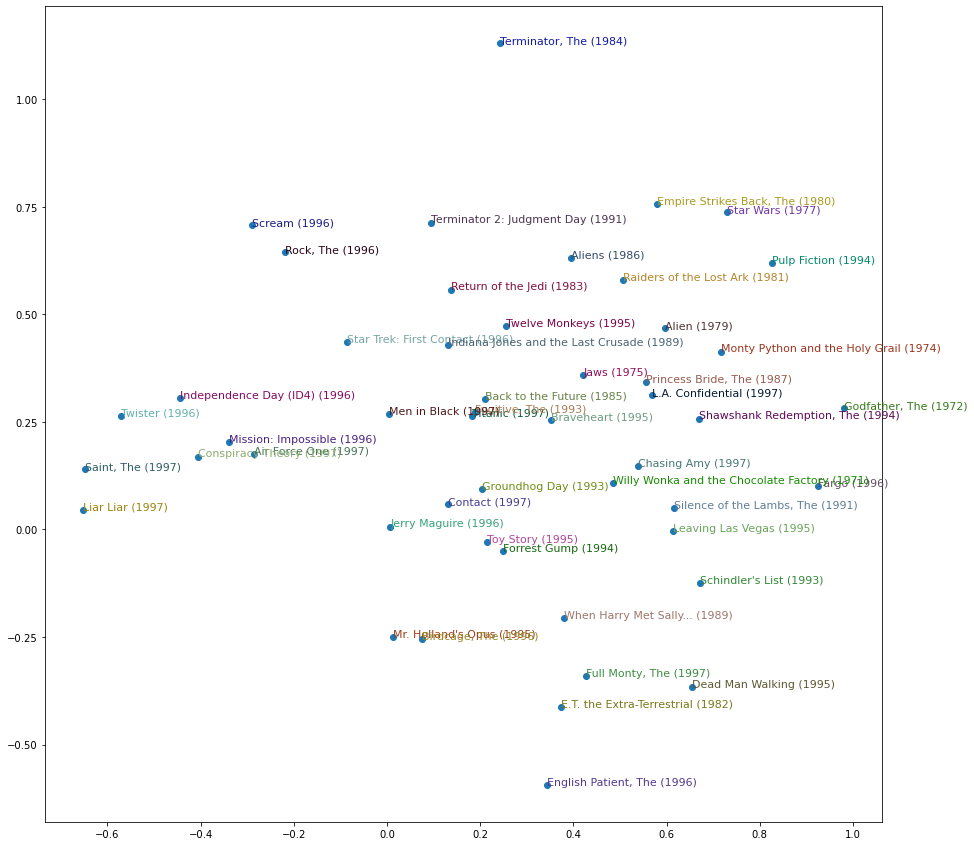

In [83]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()